# <font color='red'>**Sequence to sequence implementation**</font>

**There will be some functions that start with the word "grader" ex: grader_check_encoder(), grader_check_attention(), grader_onestepdecoder() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Note 1:**  There are many blogs on the attention mechanisum which might be misleading you,
 so do read the references completly and after that only please check the internet.
 The best things is to read the research papers and try to implement it on your own. 

**Note 2:** To complete this assignment, the reference that are mentioned will be enough.

**Note 3:** If you are starting this assignment, you might have completed minimum of 20 assignment.
 If  you are still not able to implement this algorithm you might have rushed in the previous assignments 
with out learning much and didn't spend your time productively.

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk.translate.bleu_score as bleu
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

In [3]:
! unzip '/content/drive/MyDrive/Attention mechanism/ita-eng.zip'

Archive:  /content/drive/MyDrive/Attention mechanism/ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


<font color='blue'>**Load the data**</font>

In [4]:
data = pd.read_csv('/content/ita.txt',sep="\t",header=None, names=['english','italian','meta_data'])
data.head()

,english,italian,meta_data
0,Hi.,Ciao!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
1,Run!,Corri!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
2,Run!,Corra!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
3,Run!,Correte!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4,Who?,Chi?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [5]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian,meta_data
0,hi,ciao,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
1,run,corri,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
2,run,corra,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
3,run,correte,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4,who,chi,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [6]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len','meta_data'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,corri,<start> run,run <end>
2,corra,<start> run,run <end>
3,correte,<start> run,run <end>
4,chi,<start> who,who <end>


<font color='blue'>**Preprocess data**</font>

In [7]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2,random_state=5)

In [8]:
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(275852, 3) (68964, 3)


In [9]:
train.head()

,italian,english_inp,english_out
58423,come sta sua madre,<start> how is your mother <end>,how is your mother <end> <end>
281771,sto cercando un anello di fidanzamento,<start> i am looking for an engagement ring,i am looking for an engagement ring <end>
47625,io devo andarmene da qui,<start> i must leave here,i must leave here <end>
13157,io ero geloso,<start> i was jealous,i was jealous <end>
225885,guardo la tv quasi ogni sera,<start> i watch tv almost every night,i watch tv almost every night <end>


In [10]:
validation.head()

,italian,english_inp,english_out
247572,sei sicuro che tom non sarà arrabbiato,<start> are you sure tom will not be angry,are you sure tom will not be angry <end>
237206,io penso sicuramente che sia fattibile,<start> i definitely think it is doable,i definitely think it is doable <end>
267105,tom dice di voler perdere peso,<start> tom says he wants to lose weight,tom says he wants to lose weight <end>
277264,cosha fatto con i libri,<start> what have you done with the books,what have you done with the books <end>
64297,loro non sono stupide,<start> they are not stupid,they are not stupid <end>


## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
      super().__init__()
      self.lstm_size = lstm_size
      self.embedding_layer = Embedding(input_dim=inp_vocab_size,output_dim=embedding_size,input_length=input_length, mask_zero=True)  
      self.lstm = LSTM(lstm_size,return_state=True,return_sequences=True)

    def call(self,input_sequence,states):
      '''
        This function takes a sequence input and the initial states of the encoder.
        Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
        returns -- encoder_output, last time step's hidden and cell state
      '''
      self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(self.embedding_layer(input_sequence))
      return self.lstm_output, self.lstm_state_h,self.lstm_state_c

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      self.lstm_state_h = tf.zeros([batch_size,self.lstm_size ])
      self.lstm_state_c = tf.zeros([batch_size,self.lstm_size ])
      return self.lstm_state_h, self.lstm_state_c


<font color='orange'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


In [ ]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
      super().__init__()
        #Initialize Embedding layer
        #Intialize Decoder LSTM layer    
      self.embedding_layer = Embedding(input_dim=out_vocab_size,output_dim=embedding_size,input_length=input_length)  
      self.lstm = LSTM(lstm_size,return_state=True,return_sequences=True)   
 


    def call(self,input_sequence,initial_states):
      '''
        This function takes a sequence input and the initial states of the encoder.
        Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
      
        returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
      '''
      decoder_output,decoder_final_state_h,decoder_final_state_c = self.lstm(self.embedding_layer(input_sequence),initial_state=initial_states)
      return decoder_output,decoder_final_state_h,decoder_final_state_c


<font color='orange'>**Grader function - 2**</font>

In [ ]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
        
    
    '''
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())


True


In [11]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [12]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

12858
26238


In [14]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
class Encoder_decoder(Model):
    
    def __init__(self,*params):
      super().__init__()    
        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        # inp_vocab_size,embedding_size,lstm_size,input_length)
      self.inp_vocab_size = params[0]
      self.embedding_size = params[1]
      self.lstm_size = params[2]
      self.input_length_enc = params[3]
      self.input_length_dec = params[4]
      self.out_vocab_size = params[5]
      self.encoder = Encoder(inp_vocab_size=self.inp_vocab_size+1,embedding_size=self.embedding_size[0],lstm_size=self.lstm_size,input_length=self.input_length_enc)
      self.decoder = Decoder(out_vocab_size=self.out_vocab_size+1,embedding_size=self.embedding_size[1],lstm_size=self.lstm_size,input_length=self.input_length_dec)
      self.dense = Dense(self.out_vocab_size, activation='softmax')
    
    def call(self,data):
      '''
      A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
      B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
      C. Pass the decoder_outputs into Dense layer 
      
      Return decoder_outputs
      '''
      self.input_data = data[0]
      self.output_data = data[1]
      initial_state = self.encoder.initialize_states(1024)
      encoder_output,encoder_final_state_h,encoder_final_state_c = self.encoder(self.input_data,initial_state) 
      decoder_output,_,_ = self.decoder(self.output_data,[encoder_final_state_h,encoder_final_state_c])
      current_output = self.dense(decoder_output)

      return current_output


In [ ]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model

model = Encoder_decoder(len(tknizer_ita.word_index),(50,100),256,20,20,len(tknizer_eng.word_index))
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=12, validation_data=train_dataloader, validation_steps=valid_steps)
model.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/12
269/269 [==============================] - 57s 196ms/step - loss: 3.6955 - val_loss: 1.7061
Epoch 2/12
269/269 [==============================] - 51s 188ms/step - loss: 1.6564 - val_loss: 1.4745
Epoch 3/12
269/269 [==============================] - 51s 188ms/step - loss: 1.4243 - val_loss: 1.2869
Epoch 4/12
269/269 [==============================] - 51s 190ms/step - loss: 1.2553 - val_loss: 1.1538
Epoch 5/12
269/269 [==============================] - 52s 192ms/step - loss: 1.1288 - val_loss: 1.0460
Epoch 6/12
269/269 [==============================] - 51s 191ms/step - loss: 1.0259 - val_loss: 0.9489
Epoch 7/12
269/269 [==============================] - 51s 190ms/step - loss: 0.9283 - val_loss: 0.8624
Epoch 8/12
269/269 [==============================] - 51s 189ms/step - loss: 0.8478 - val_loss: 0.7885
Epoch 9/12
269/269 [==============================] - 51s 189ms/step - loss: 0.7757 - val_loss: 0.7214
Epoch 10/12
269/269 [==============================] - 51s 190ms/step - l

In [ ]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
  D. till we reach max_length of decoder or till the model predicted word <end>:
          predicted_out,state_h,state_c=model.layers[1](dec_input,states)
          pass the predicted_out to the dense layer
          update the states=[state_h,state_c]
          And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
          Update the input_to_decoder with current predictions
  F. Return the predicted sentence
  '''

  token_sequence = tknizer_ita.texts_to_sequences([input_sentence])
  pad_seq = pad_sequences(token_sequence, padding='post', maxlen=20)

  initial_state = model.layers[0].initialize_states(1024)
 
  encoder_output,hidden_state_enc,cell_state_enc = model.layers[0](pad_seq,initial_state)
  pred_sent = []
  state_values = [hidden_state_enc,cell_state_enc]
  cur_vec = tf.expand_dims([tknizer_eng.word_index['<start>']],0)

  for i in range(20):

    cur_emb = model.layers[1].embedding_layer(cur_vec)
    decoder_output,state_h,state_c = model.layers[1].lstm(cur_emb,state_values)
    predicted_out = model.layers[2](decoder_output)
    state_values = [state_h,state_c]
    cur_vec = np.reshape(np.argmax(predicted_out),(1,1))

    if np.squeeze(cur_vec) != tknizer_eng.word_index['<end>']:
      pred_sent.append(tknizer_eng.index_word[int(np.squeeze(cur_vec))]) 
    else:  
      break
     
  return ' '.join(pred_sent)



In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

rand_val = np.random.randint(0,len(validation),size=(1000))
iter_val = validation.iloc[rand_val,:].apply(lambda x: bleu.sentence_bleu(x['english_out'][:-6],predict(x['italian'])),axis=1)
print("BLEU score:",np.sum(iter_val.values)/1000)

BLEU score: 0.8081453347183427


## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [21]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__()
        self.lstm_size = lstm_size

        self.embedding = Embedding(input_dim=inp_vocab_size,output_dim=embedding_size,input_length=input_length)  
        self.lstm = LSTM(lstm_size,return_state=True,return_sequences=True)


    def call(self,input_sequence,states):
      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
      '''
      input_embedd = self.embedding(input_sequence)
      self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
      return self.lstm_output, self.lstm_state_h,self.lstm_state_c

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      
      self.lstm_state_h = tf.zeros([batch_size,self.lstm_size ])
      self.lstm_state_c = tf.zeros([batch_size,self.lstm_size ])
      return [self.lstm_state_h,self.lstm_state_c]

<font color='cyan'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='blue'>**Attention**</font>

In [20]:
#Reference: https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function

class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()
    self.scoring_function = scoring_function
    self.att_units = att_units


    # Please go through the reference notebook and research paper to complete the scoring functions

    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
      self.score = 0
      
    if scoring_function == 'general':
      # Intialize variables needed for General score function here
      self.W1 = tf.keras.layers.Dense(self.att_units)
      self.score = 0

    elif scoring_function == 'concat':
      # Intialize variables needed for Concat score function here
      self.W1 = tf.keras.layers.Dense(self.att_units)
      self.W2 = tf.keras.layers.Dense(self.att_units)
      self.V = tf.keras.layers.Dense(1)
      self.score = 0
  
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    
    if self.scoring_function == 'dot':
        # Implement Dot score function here
        query_with_time_axis = tf.expand_dims(decoder_hidden_state, 1)
        self.score = tf.matmul(encoder_output, tf.transpose(query_with_time_axis, perm=[0,2,1]))
       
    elif self.scoring_function == 'general':
        # Implement General score function here
        query_with_time_axis = tf.expand_dims(decoder_hidden_state, 1)
        self.score = tf.matmul(self.W1(encoder_output),tf.transpose(query_with_time_axis, perm=[0,2,1]))

    elif self.scoring_function == 'concat':
        # Implement General score function here
        query_with_time_axis = tf.expand_dims(decoder_hidden_state, 1)
        self.score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(encoder_output)))
        

    attention_weights = tf.nn.softmax(self.score, axis=1)
    context_vector = attention_weights * encoder_output
    context_vector = tf.reduce_sum(context_vector, axis=1)   
    
    return context_vector, attention_weights
    

<font color='cyan'>**Grader function - 2**</font>

In [ ]:
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


<font color='blue'>**OneStepDecoder**</font>

In [19]:
#Reference: https://datascience.stackexchange.com/questions/64433/symbolicexception-inputs-to-eager-execution-function-cannot-be-keras-symbolic-t

class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed
      super().__init__()
      self.tar_vocab_size = tar_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.score_fun = score_fun
      self.att_units = att_units
      self.attention = Attention(self.score_fun,self.att_units)
      self.embedding = Embedding(input_dim=self.tar_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,mask_zero=True)
      self.lstm = LSTM(units=self.dec_units,return_sequences=True,return_state=True)
      self.dense = Dense(self.tar_vocab_size)



  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    output_embedding = self.embedding(input_to_decoder)
    context_vector,attention_weights = self.attention(state_h,encoder_output)
    conc_vec = tf.concat([tf.expand_dims(context_vector,1),output_embedding], axis=-1)
    lstm_out, lstm_h, lstm_c = self.lstm(conc_vec)
    decoder_output = self.dense(lstm_out)

    return tf.squeeze(decoder_output), lstm_h, lstm_c, attention_weights, context_vector 
    



<font color='cyan'>**Grader function - 3**</font>

In [ ]:
def grader_onestepdecoder(score_fun):
    
    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=One_Step_Decoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))
    

True
True
True


<font color='blue'>**Decoder**</font>

In [22]:
#Reference: https://github.com/Douboo/tf_env_debug/blob/master/custom_layers_and_model_subclassing_API.ipynb

class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super().__init__()
      self.tar_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.score_fun = score_fun
      self.att_units = att_units
      self.onestepdecoder = One_Step_Decoder(self.tar_vocab_size, self.embedding_dim, self.input_length, self.dec_units , self.score_fun , self.att_units)


    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        array = tf.TensorArray(tf.float32, size=20)
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        for i in range(20):
          output,state_h,state_c,attention_weights,context_vector=self.onestepdecoder(input_to_decoder[:,i:i+1],encoder_output,decoder_hidden_state,decoder_cell_state)  
          array = array.write(i,output)
        array = tf.transpose(array.stack(), [1, 0, 2])
        
        return array 
        
    

The value 20 has been hardcoded specifically during training of the model because input_to_decoder.shape[1] was returning None. 

<font color='cyan'>**Grader function - 4**</font>

In [ ]:
def grader_decoder(score_fun):
    
    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    out_vocab_size=13 
    embedding_dim=12 
    input_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


<font color='blue'>**Encoder Decoder model**</font>

In [16]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,*params):
    super().__init__()
    #Intialize objects from encoder decoder
    self.inp_vocab_size = params[0]
    self.embedding_size = params[1]
    self.lstm_size = params[2]
    self.input_length_enc = params[3]
    self.input_length_dec = params[4]
    self.out_vocab_size = params[5]
    self.score_fun = params[6]
    self.att_units = params[7]
    self.encoder = Encoder(inp_vocab_size=self.inp_vocab_size+1,embedding_size=self.embedding_size[0],lstm_size=self.lstm_size,input_length=self.input_length_enc)
    self.decoder = Decoder(out_vocab_size=self.out_vocab_size+1,embedding_dim=self.embedding_size[1],dec_units=self.lstm_size,input_length=self.input_length_dec,score_fun=self.score_fun,att_units=self.att_units)

  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    self.input_data = data[0]
    self.output_data = data[1]
    initial_state = self.encoder.initialize_states(1024)
    encoder_output,encoder_final_state_h,encoder_final_state_c = self.encoder(self.input_data,initial_state) 
    decoder_output = self.decoder(self.output_data,encoder_output,encoder_final_state_h,encoder_final_state_c)
    
    return decoder_output




<font color='blue'>**Custom loss function**</font>

In [17]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def custom_lossfunction(targets,logits):

  # Custom loss function that will not consider the loss for padded zeros.
  # Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function
  
  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  loss_ = loss_object(targets,logits)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

<font color='blue'>**Training**</font>

Implement dot function here.

In [ ]:
# Implement teacher forcing while training your model. You can do it two ways.
# Prepare your data, encoder_input,decoder_input and decoder_output
# if decoder input is 
# <start> Hi how are you
# decoder output should be
# Hi How are you <end>
# i.e when you have send <start>-- decoder predicted Hi, 'Hi' decoder predicted 'How' .. e.t.c

# or
 
# model.fit([train_ita,train_eng],train_eng[:,1:]..)
# Note: If you follow this approach some grader functions might return false and this is fine.

model2_dot = encoder_decoder(len(tknizer_ita.word_index),(128,128),64,20,20,len(tknizer_eng.word_index),'dot',64)
optimizer = tf.keras.optimizers.Adam(0.005)
model2_dot.compile(optimizer=optimizer,loss=custom_lossfunction)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model2_dot.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=test_dataloader, validation_steps=valid_steps)
model2_dot.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
269/269 [==============================] - 111s 312ms/step - loss: 2.1253 - val_loss: 1.6707
Epoch 2/20
269/269 [==============================] - 77s 286ms/step - loss: 1.6252 - val_loss: 1.4590
Epoch 3/20
269/269 [==============================] - 77s 286ms/step - loss: 1.4379 - val_loss: 1.3812
Epoch 4/20
269/269 [==============================] - 77s 285ms/step - loss: 1.3723 - val_loss: 1.3473
Epoch 5/20
269/269 [==============================] - 77s 287ms/step - loss: 1.3389 - val_loss: 1.3269
Epoch 6/20
269/269 [==============================] - 77s 287ms/step - loss: 1.3166 - val_loss: 1.3133
Epoch 7/20
269/269 [==============================] - 78s 288ms/step - loss: 1.3018 - val_loss: 1.3031
Epoch 8/20
269/269 [==============================] - 77s 285ms/step - loss: 1.2913 - val_loss: 1.2959
Epoch 9/20
269/269 [==============================] - 77s 285ms/step - loss: 1.2799 - val_loss: 1.2901
Epoch 10/20
269/269 [==============================] - 77s 284ms/step - 

In [ ]:
model2_dot.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=5, validation_data=test_dataloader, validation_steps=valid_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
269/269 [==============================] - 77s 287ms/step - loss: 0.5549 - val_loss: 0.6290
Epoch 2/5
269/269 [==============================] - 77s 286ms/step - loss: 0.5194 - val_loss: 0.6059
Epoch 3/5
269/269 [==============================] - 77s 285ms/step - loss: 0.4885 - val_loss: 0.5855
Epoch 4/5
269/269 [==============================] - 77s 287ms/step - loss: 0.4617 - val_loss: 0.5685
Epoch 5/5
269/269 [==============================] - 76s 284ms/step - loss: 0.4383 - val_loss: 0.5543


In [ ]:
model2_dot.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=5, validation_data=test_dataloader, validation_steps=valid_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
269/269 [==============================] - 77s 286ms/step - loss: 0.4175 - val_loss: 0.5434
Epoch 2/5
269/269 [==============================] - 78s 290ms/step - loss: 0.3999 - val_loss: 0.5318
Epoch 3/5
269/269 [==============================] - 77s 288ms/step - loss: 0.3836 - val_loss: 0.5238
Epoch 4/5
269/269 [==============================] - 77s 286ms/step - loss: 0.3694 - val_loss: 0.5175
Epoch 5/5
269/269 [==============================] - 77s 286ms/step - loss: 0.3566 - val_loss: 0.5103


## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker



def plot_attention(attention, sentence, predicted_sentence):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate

  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


<font color='blue'>**Predict the sentence translation**</font>

In [ ]:
def predict_dot(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  token_sequence = tknizer_ita.texts_to_sequences([input_sentence])
  pad_seq = pad_sequences(token_sequence, padding='post', maxlen=20)

  initial_state = model2_dot.layers[0].initialize_states(1024)
  encoder_output,hidden_state_enc,cell_state_enc = model2_dot.layers[0](pad_seq,initial_state)
  state_values = [hidden_state_enc,cell_state_enc]
  cur_vec = tf.expand_dims([tknizer_eng.word_index['<start>']],0)

  global attention_plot
  attention_plot = np.zeros((20, 20))
  result = ''
  predictions = []

  for f in range(20):
    output,state_h,state_c,attention_weights,context_vector = model2_dot.layers[1].onestepdecoder(cur_vec, encoder_output, state_values[0],state_values[1])
    state_values = [state_h,state_c]

    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[f] = attention_weights.numpy()
    
    predicted_id = tf.argmax(output).numpy()

    if tknizer_eng.index_word[predicted_id] == '<end>':
      break
    
    cur_vec = tf.expand_dims([predicted_id], 0)
    result += tknizer_eng.index_word[predicted_id] + ' '

  return result.strip()




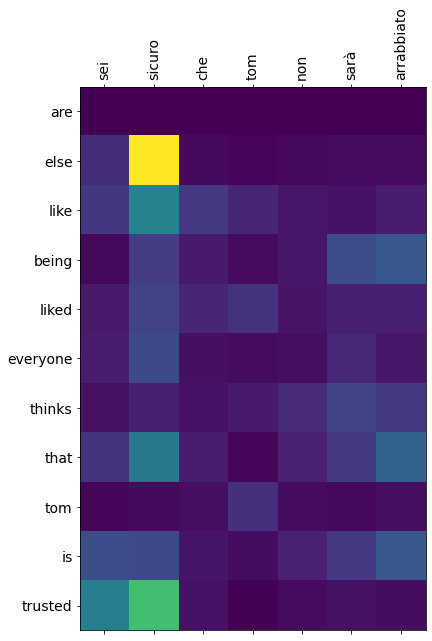

In [ ]:
input_sentence = validation.iloc[0,:]['italian']
result = predict_dot(input_sentence)
attention_plot = attention_plot[:len(result.split(' ')), :len(input_sentence.split(' '))]
plot_attention(attention_plot, input_sentence.split(' '), result.strip().split(' '))

<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

rand_val = np.random.randint(0,len(validation),size=(1000))
iter_val = validation.iloc[rand_val,:].apply(lambda x: bleu.sentence_bleu(x['english_out'][:-6],predict_dot(x['italian'])),axis=1)
print("BLEU score:",np.sum(iter_val.values)/1000)

BLEU score: 0.7563061593669899


<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [23]:
#Compile and train your model on general scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html


model2_general = encoder_decoder(len(tknizer_ita.word_index),(128,128),64,20,20,len(tknizer_eng.word_index),'general',64)
optimizer = tf.keras.optimizers.Adam(0.005)
model2_general.compile(optimizer=optimizer,loss=custom_lossfunction)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model2_general.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data=test_dataloader, validation_steps=valid_steps)
model2_general.summary()

Epoch 1/30
269/269 [==============================] - 111s 314ms/step - loss: 2.1263 - val_loss: 1.6356
Epoch 2/30
269/269 [==============================] - 79s 292ms/step - loss: 1.5772 - val_loss: 1.4396
Epoch 3/30
269/269 [==============================] - 79s 294ms/step - loss: 1.4232 - val_loss: 1.3719
Epoch 4/30
269/269 [==============================] - 78s 291ms/step - loss: 1.3606 - val_loss: 1.3406
Epoch 5/30
269/269 [==============================] - 78s 290ms/step - loss: 1.3307 - val_loss: 1.3221
Epoch 6/30
269/269 [==============================] - 78s 290ms/step - loss: 1.3117 - val_loss: 1.3099
Epoch 7/30
269/269 [==============================] - 78s 290ms/step - loss: 1.2982 - val_loss: 1.3006
Epoch 8/30
269/269 [==============================] - 78s 291ms/step - loss: 1.2872 - val_loss: 1.2936
Epoch 9/30
269/269 [==============================] - 78s 292ms/step - loss: 1.2790 - val_loss: 1.2731
Epoch 10/30
269/269 [==============================] - 78s 291ms/step - 

In [24]:
def predict_general(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  token_sequence = tknizer_ita.texts_to_sequences([input_sentence])
  pad_seq = pad_sequences(token_sequence, padding='post', maxlen=20)

  initial_state = model2_general.layers[0].initialize_states(1024)
  encoder_output,hidden_state_enc,cell_state_enc = model2_general.layers[0](pad_seq,initial_state)
  state_values = [hidden_state_enc,cell_state_enc]
  cur_vec = tf.expand_dims([tknizer_eng.word_index['<start>']],0)

  global attention_plot
  attention_plot = np.zeros((20, 20))
  result = ''
  predictions = []

  for f in range(20):
    output,state_h,state_c,attention_weights,context_vector = model2_general.layers[1].onestepdecoder(cur_vec, encoder_output, state_values[0],state_values[1])
    state_values = [state_h,state_c]

    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[f] = attention_weights.numpy()
    
    predicted_id = tf.argmax(output).numpy()

    if tknizer_eng.index_word[predicted_id] == '<end>':
      break
    
    cur_vec = tf.expand_dims([predicted_id], 0)
    result += tknizer_eng.index_word[predicted_id] + ' '

  return result.strip()

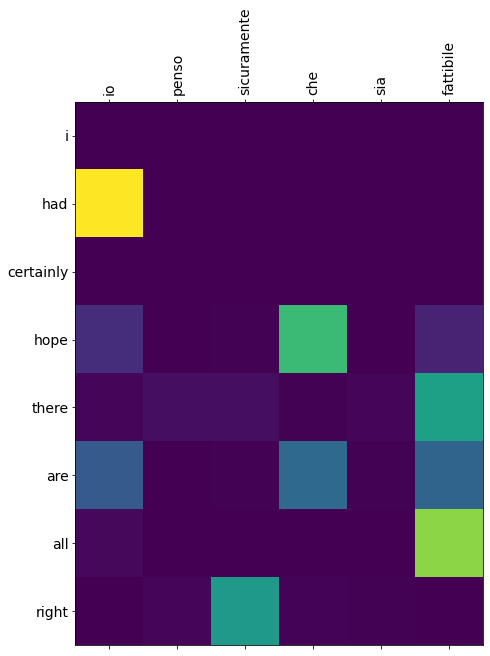

In [28]:
input_sentence = validation.iloc[1,:]['italian']
result = predict_general(input_sentence)
attention_plot = attention_plot[:len(result.split(' ')), :len(input_sentence.split(' '))]
plot_attention(attention_plot, input_sentence.split(' '), result.strip().split(' '))

In [29]:
rand_val = np.random.randint(0,len(validation),size=(1000))
iter_val = validation.iloc[rand_val,:].apply(lambda x: bleu.sentence_bleu(x['english_out'][:-6],predict_general(x['italian'])),axis=1)
print("BLEU score:",np.sum(iter_val.values)/1000)

BLEU score: 0.7593959731689988


<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [30]:
#Compile and train your model on concat scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

model2_concat = encoder_decoder(len(tknizer_ita.word_index),(128,128),64,20,20,len(tknizer_eng.word_index),'concat',64)
optimizer = tf.keras.optimizers.Adam(0.005)
model2_concat.compile(optimizer=optimizer,loss=custom_lossfunction)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model2_concat.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data=test_dataloader, validation_steps=valid_steps)
model2_concat.summary()

Epoch 1/30
269/269 [==============================] - 115s 327ms/step - loss: 2.1242 - val_loss: 1.6146
Epoch 2/30
269/269 [==============================] - 80s 298ms/step - loss: 1.5052 - val_loss: 1.2322
Epoch 3/30
269/269 [==============================] - 80s 297ms/step - loss: 1.1659 - val_loss: 0.9944
Epoch 4/30
269/269 [==============================] - 80s 298ms/step - loss: 0.9353 - val_loss: 0.8293
Epoch 5/30
269/269 [==============================] - 81s 300ms/step - loss: 0.7679 - val_loss: 0.7082
Epoch 6/30
269/269 [==============================] - 80s 297ms/step - loss: 0.6390 - val_loss: 0.6192
Epoch 7/30
269/269 [==============================] - 80s 298ms/step - loss: 0.5389 - val_loss: 0.5579
Epoch 8/30
269/269 [==============================] - 81s 300ms/step - loss: 0.4666 - val_loss: 0.5144
Epoch 9/30
269/269 [==============================] - 80s 297ms/step - loss: 0.4122 - val_loss: 0.4832
Epoch 10/30
269/269 [==============================] - 81s 300ms/step - 

In [31]:
def predict_concat(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  token_sequence = tknizer_ita.texts_to_sequences([input_sentence])
  pad_seq = pad_sequences(token_sequence, padding='post', maxlen=20)

  initial_state = model2_concat.layers[0].initialize_states(1024)
  encoder_output,hidden_state_enc,cell_state_enc = model2_concat.layers[0](pad_seq,initial_state)
  state_values = [hidden_state_enc,cell_state_enc]
  cur_vec = tf.expand_dims([tknizer_eng.word_index['<start>']],0)

  global attention_plot
  attention_plot = np.zeros((20, 20))
  result = ''
  predictions = []

  for f in range(20):
    output,state_h,state_c,attention_weights,context_vector = model2_concat.layers[1].onestepdecoder(cur_vec, encoder_output, state_values[0],state_values[1])
    state_values = [state_h,state_c]

    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[f] = attention_weights.numpy()
    
    predicted_id = tf.argmax(output).numpy()
    # predictions.append(predicted_id)

    if tknizer_eng.index_word[predicted_id] == '<end>':
      break
    
    cur_vec = tf.expand_dims([predicted_id], 0)
    result += tknizer_eng.index_word[predicted_id] + ' '

  return result.strip()

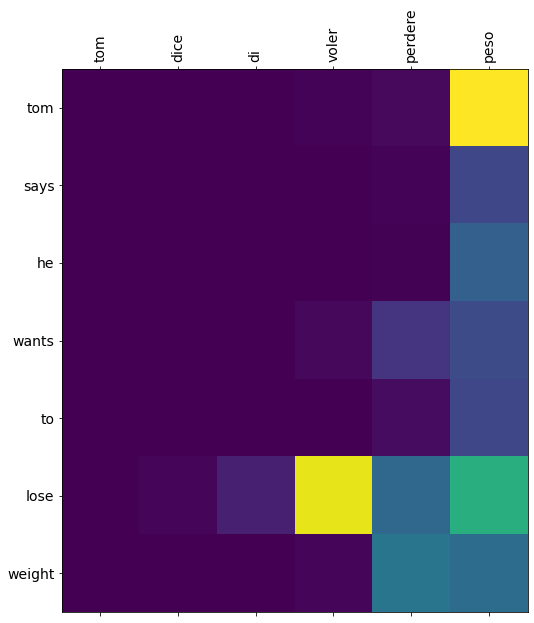

In [33]:
input_sentence = validation.iloc[2,:]['italian']
result = predict_concat(input_sentence)
attention_plot = attention_plot[:len(result.split(' ')), :len(input_sentence.split(' '))]
plot_attention(attention_plot, input_sentence.split(' '), result.strip().split(' '))

In [34]:
rand_val = np.random.randint(0,len(validation),size=(1000))
iter_val = validation.iloc[rand_val,:].apply(lambda x: bleu.sentence_bleu(x['english_out'][:-6],predict_concat(x['italian'])),axis=1)
print("BLEU score:",np.sum(iter_val.values)/1000)

BLEU score: 0.8086566488463641


#Write your observations on each of the scoring function - 

We created 3 different models, where each was implemented with one of the three attention score functions. All of them were trained for 30 epochs each. The models trainined with the concat and general score functions had a similar BLUE score of approximately 0.75. The model trainined using the concat function had a significantly greated BLEU score of approximately 0.80.